In [81]:
#Obliczenia  i analiza  danych
import numpy as np
import pandas as pd

#wizualiacja 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set_palette('icefire_r', 2)


%matplotlib inline
#Przetwarzanie

from sklearn.preprocessing import OrdinalEncoder

from sklearn.impute import KNNImputer
# Baza danych gównych do nauki modelu
train = pd.read_csv("train.csv") 
# Baza danych Titanica do sprawdzenia modelu
test = pd.read_csv("test.csv")

In [82]:
train

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


In [83]:
print(train.columns)

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')


# Czyszczenie i przygotowanie danych

In [84]:
print(pd.isnull(train).sum())

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64


In [85]:
print(pd.isnull(test).sum())

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64


#### Przygotwanie kolumny 'Cabin' do encodowania

In [86]:
def extract_cabin_details(cabin):
  try:
    parts = cabin.split('/')
    if len(parts) == 2:
      cabin_type, deck_level = parts
      section_number = None
    elif len(parts) == 3:
      cabin_type, deck_level, section_number = parts
    else:
      raise ValueError("Nieprawidłowy format wartości w kolumnie Cabin")
    return cabin_type, int(deck_level), section_number
  except ValueError:
    return None, None, None

for df in [train, test]:
  df['Cabin_Filled'] = df['Cabin'].notna()

  # Ekstrakcja parametrów
  df.loc[df['Cabin_Filled'], 'Cabin_Type'] = df['Cabin'][df['Cabin_Filled']].apply(extract_cabin_details).str[0]
  df.loc[df['Cabin_Filled'], 'Cabin_Deck'] = df['Cabin'][df['Cabin_Filled']].apply(extract_cabin_details).str[1]
  df.loc[df['Cabin_Filled'], 'Cabin_Section'] = df['Cabin'][df['Cabin_Filled']].apply(extract_cabin_details).str[2]

  # Uzupełnianie wartości NaN
  df['Cabin_Type'].replace('NaN', np.nan, inplace=True)
  df['Cabin_Deck'].replace('NaN', np.nan, inplace=True)
  df['Cabin_Section'].replace('NaN', np.nan, inplace=True)

  # Konwersja typów
  df['Cabin_Deck'] = df['Cabin_Deck'].astype('float')
  df['Cabin_Type'] = df['Cabin_Type'].astype('category')
  df['Cabin_Section'] = df['Cabin_Section'].astype('category')

  # Usunięcie kolumny pomocniczej
  del df['Cabin_Filled']

#### Przygotwanie kolumny Name do zastępienia jej kolumną rodzina

In [87]:
for df in [train, test]:
  # Create Last_Name column, handling missing values
  df['Last_Name'] = df['Name'].str.split().str[-1].fillna(pd.NA)

In [88]:
def find_groups(df):
    groups = {}
    for name, group in df.groupby('Last_Name'):
        for cabin, subgroup in group.groupby('Cabin'):
            if len(subgroup) > 1:
                if subgroup['Family'].all():
                    subgroup['Family'] = 1
                groups[name] = list(subgroup.index)

    return groups

# Zastosowanie funkcji do DataFrame'ów test i train
for df in [test, train]:
    df['Family'] = 0
    groups = find_groups(df.copy())
    for name, group in groups.items():
        df.loc[group, 'Family'] = 1
train['Family'].value_counts()

Family
0    6513
1    2180
Name: count, dtype: int64

#### Ordinal encoding

In [89]:
enc = OrdinalEncoder()
Enc_col = ['HomePlanet', 'CryoSleep', 'Destination' , 'VIP', 'Cabin_Type', 'Cabin_Section' ]

# Fit the encoder and create the mapping for each column separately
categories = {}
for col in Enc_col:
    for df in [train, test]:
        df[col + '_Enc'] = enc.fit_transform(df[col].values.reshape(-1, 1))
    categories[col] = enc.categories_[0]  # Store categories for the current column

# Print the mapping
for col in Enc_col:
    print(f"Kolumna: {col}")
    for i, category in enumerate(categories[col]):
        print(f"  Wartość zakodowana: {i} -> Wartość początkowa: {category}")

Kolumna: HomePlanet
  Wartość zakodowana: 0 -> Wartość początkowa: Earth
  Wartość zakodowana: 1 -> Wartość początkowa: Europa
  Wartość zakodowana: 2 -> Wartość początkowa: Mars
  Wartość zakodowana: 3 -> Wartość początkowa: nan
Kolumna: CryoSleep
  Wartość zakodowana: 0 -> Wartość początkowa: False
  Wartość zakodowana: 1 -> Wartość początkowa: True
  Wartość zakodowana: 2 -> Wartość początkowa: nan
Kolumna: Destination
  Wartość zakodowana: 0 -> Wartość początkowa: 55 Cancri e
  Wartość zakodowana: 1 -> Wartość początkowa: PSO J318.5-22
  Wartość zakodowana: 2 -> Wartość początkowa: TRAPPIST-1e
  Wartość zakodowana: 3 -> Wartość początkowa: nan
Kolumna: VIP
  Wartość zakodowana: 0 -> Wartość początkowa: False
  Wartość zakodowana: 1 -> Wartość początkowa: True
  Wartość zakodowana: 2 -> Wartość początkowa: nan
Kolumna: Cabin_Type
  Wartość zakodowana: 0 -> Wartość początkowa: A
  Wartość zakodowana: 1 -> Wartość początkowa: B
  Wartość zakodowana: 2 -> Wartość początkowa: C
  Wartoś

In [90]:
categorical_features = ['PassengerId','HomePlanet', 'CryoSleep', 'Cabin', 'Destination' , 'Name', 'VIP', 'Cabin_Type', 'Last_Name',  'Cabin_Section']
for df in [train, test]:
     df.drop(columns=categorical_features, inplace=True)
print(pd.isnull(train).sum())

Age                  179
RoomService          181
FoodCourt            183
ShoppingMall         208
Spa                  183
VRDeck               188
Transported            0
Cabin_Deck           199
Family                 0
HomePlanet_Enc       201
CryoSleep_Enc        217
Destination_Enc      182
VIP_Enc              203
Cabin_Type_Enc       199
Cabin_Section_Enc    199
dtype: int64


In [91]:
train.columns

Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Transported', 'Cabin_Deck', 'Family', 'HomePlanet_Enc',
       'CryoSleep_Enc', 'Destination_Enc', 'VIP_Enc', 'Cabin_Type_Enc',
       'Cabin_Section_Enc'],
      dtype='object')

#### Uzupełnianie brakujących wartości

In [92]:
def fill_missing_values(df):
  # Create KNN Imputer with 5 neighbors
  imputer = KNNImputer(n_neighbors=5)
  # Identify columns with missing values
  cols_with_missing = [col for col in df.columns if df[col].isna().any()]
  # Impute values
  df_imputed = imputer.fit_transform(df)
  # Assign all imputed columns back to the DataFrame
  df[:] = df_imputed
  return df

for df in [train, test]:
  df = fill_missing_values(df)


#### Modele standaryzujące

In [93]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
# Wybór kolumn do standaryzacji
kolumny = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Tworzenie obiektu StandardScaler
scaler = RobustScaler()

# Dopasowanie i transformacja danych treningowych
scaler.fit(train[kolumny])
train_scaled = scaler.transform(train[kolumny])

# Transformacja danych testowych
test_scaled = scaler.transform(test[kolumny])

# Dodanie przetworzonych kolumn do data frame
for df in [train, test]:
  df[kolumny] = scaler.transform(df[kolumny])

In [94]:
train.groupby('Transported').mean().round(2)

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Cabin_Deck,Family,HomePlanet_Enc,CryoSleep_Enc,Destination_Enc,VIP_Enc,Cabin_Type_Enc,Cabin_Section_Enc
Transported,,,,,,,,,,,,,,
0.0,29.87,7.41,4.83,5.78,8.85,10.33,625.01,0.2,0.57,0.14,1.57,0.03,4.52,0.45
1.0,27.75,1.24,6.63,6.09,0.99,1.36,576.58,0.3,0.76,0.59,1.39,0.02,4.10,0.56


In [95]:
from sklearn.preprocessing import PolynomialFeatures
kolumny = ['Spa', 'VRDeck']  # Ensure these names match both dataframes

# Create PolynomialFeatures object
poly = PolynomialFeatures(degree=2, interaction_only=True ) #interaction_only=True

# Dodaj nową kolumnę do każdego dataframu
for df in [train, test]:
    # Dopasuj i transformuj dane
    X = poly.fit_transform(df[kolumny])

    # Dodaj nazwę interakcji jako nową kolumnę
    df['Interakcja'] = X[:, -1]  # Zakłada, że ostatnia kolumna zawiera interakcję

train.groupby('Transported').corr().round(2)

Age  RoomService  FoodCourt  ShoppingMall  \
Transported                                                                 
0.0         Age                1.00         0.06       0.14          0.04   
            RoomService        0.06         1.00      -0.03          0.07   
            FoodCourt          0.14        -0.03       1.00         -0.05   
            ShoppingMall       0.04         0.07      -0.05          1.00   
            Spa                0.15        -0.05       0.38          0.02   
            VRDeck             0.11        -0.08       0.35         -0.02   
            Cabin_Deck        -0.09        -0.03      -0.20         -0.01   
            Family            -0.06        -0.01       0.12          0.00   
            HomePlanet_Enc     0.18         0.35       0.11          0.21   
            CryoSleep_Enc     -0.14        -0.17      -0.13         -0.14   
            Destination_Enc   -0.01         0.02      -0.15          0.01   
            VIP_Enc            0.10         0.07       0.09          0.04   
            Cabin_Type_Enc    -0.24        -0.09      -0.42         -0.06   
            Cabin_Section_Enc  0.01         0.03      -0.00         -0.01   
            Interakcja         0.04        -0.03       0.26         -0.01   
1.0         Age                1.00         0.05       0.13          0.03   
            RoomService        0.05         1.00       0.05          0.11   
            FoodCourt          0.13         0.05       1.00          0.00   
            ShoppingMall       0.03         0.11       0.00          1.00   
            Spa                0.11         0.08       0.30          0.08   
            VRDeck             0.10         0.04       0.38          0.03   
            Cabin_Deck        -0.18         0.00      -0.18          0.01   
            Family            -0.15        -0.07       0.03         -0.07   
            HomePlanet_Enc     0.13         0.06       0.04          0.04   
            CryoSleep_Enc      0.01        -0.28      -0.32         -0.29   
            Destination_Enc   -0.02         0.04      -0.08          0.04   
            VIP_Enc            0.07         0.01       0.17          0.01   
            Cabin_Type_Enc    -0.28        -0.00      -0.27         -0.02   
            Cabin_Section_Enc  0.03        -0.01       0.02         -0.03   
            Interakcja         0.05         0.03       0.26          0.01   

                                Spa  VRDeck  Cabin_Deck  Family  \
Transported                                                       
0.0         Age                0.15    0.11       -0.09   -0.06   
            RoomService       -0.05   -0.08       -0.03   -0.01   
            FoodCourt          0.38    0.35       -0.20    0.12   
            ShoppingMall       0.02   -0.02       -0.01    0.00   
            Spa                1.00    0.11       -0.18    0.11   
            VRDeck             0.11    1.00       -0.19    0.12   
            Cabin_Deck        -0.18   -0.19        1.00   -0.10   
            Family             0.11    0.12       -0.10    1.00   
            HomePlanet_Enc     0.12    0.10       -0.26    0.12   
            CryoSleep_Enc     -0.14   -0.13        0.01    0.07   
            Destination_Enc   -0.12   -0.14        0.05   -0.05   
            VIP_Enc            0.05    0.14       -0.10    0.04   
            Cabin_Type_Enc    -0.38   -0.42        0.47   -0.15   
            Cabin_Section_Enc  0.03    0.01       -0.05    0.01   
            Interakcja         0.44    0.41       -0.10    0.09   
1.0         Age                0.11    0.10       -0.18   -0.15   
            RoomService        0.08    0.04        0.00   -0.07   
            FoodCourt          0.30    0.38       -0.18    0.03   
            ShoppingMall       0.08    0.03        0.01   -0.07   
            Spa                1.00    0.19       -0.11   -0.01   
            VRDeck             0.19    1.00       -0.11    0.00   
            Cabin_Deck    

In [96]:
train.corr()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Cabin_Deck,Family,HomePlanet_Enc,CryoSleep_Enc,Destination_Enc,VIP_Enc,Cabin_Type_Enc,Cabin_Section_Enc,Interakcja
Age,1.000000,0.068137,0.128823,0.034960,0.123138,0.102110,-0.073759,-0.132862,-0.121499,0.141347,-0.075064,-0.007796,0.091624,-0.249389,0.008759,0.032790
RoomService,0.068137,1.000000,-0.014381,0.058818,0.011577,-0.019364,-0.242373,-0.008928,-0.053101,0.213446,-0.251593,0.048768,0.059055,-0.022390,-0.011532,-0.006288
FoodCourt,0.128823,-0.014381,1.000000,-0.012472,0.223018,0.225541,0.044453,-0.181317,0.067324,0.069651,-0.209717,-0.108922,0.125598,-0.318990,0.018852,0.143876
ShoppingMall,0.034960,0.058818,-0.012472,1.000000,0.018066,-0.006671,0.007379,0.002221,-0.040911,0.102719,-0.214928,0.026409,0.020338,-0.031696,-0.020467,-0.007142
Spa,0.123138,0.011577,0.223018,0.018066,1.000000,0.148953,-0.219825,-0.126302,0.042701,0.054562,-0.204666,-0.056235,0.060387,-0.222986,0.000998,0.444346
VRDeck,0.102110,-0.019364,0.225541,-0.006671,0.148953,1.000000,-0.205410,-0.138690,0.051949,0.039184,-0.198648,-0.071606,0.126329,-0.252258,-0.007461,0.414953
Transported,-0.073759,-0.242373,0.044453,0.007379,-0.219825,-0.205410,1.000000,-0.047693,0.124258,0.118249,0.465049,-0.111272,-0.038130,-0.119305,0.103326,-0.086883
Cabin_Deck,-0.132862,-0.008928,-0.181317,0.002221,-0.126302,-0.138690,-0.047693,1.000000,-0.106540,-0.203481,-0.039372,0.106504,-0.097627,0.532670,-0.038727,-0.071483
Family,-0.121499,-0.053101,0.067324,-0.040911,0.042701,0.051949,0.124258,-0.106540,1.000000,0.144139,0.134929,-0.063352,0.017168,-0.169620,0.035244,0.045905
HomePlanet_Enc,0.141347,0.213446,0.069651,0.102719,0.054562,0.039184,0.118249,-0.203481,0.144139,1.000000,0.087741,0.034856,0.129037,-0.416118,-0.000259,0.036369


## Wizualizacja

Text(0.5, 1.05, 'Macierz korelacji Perasona')

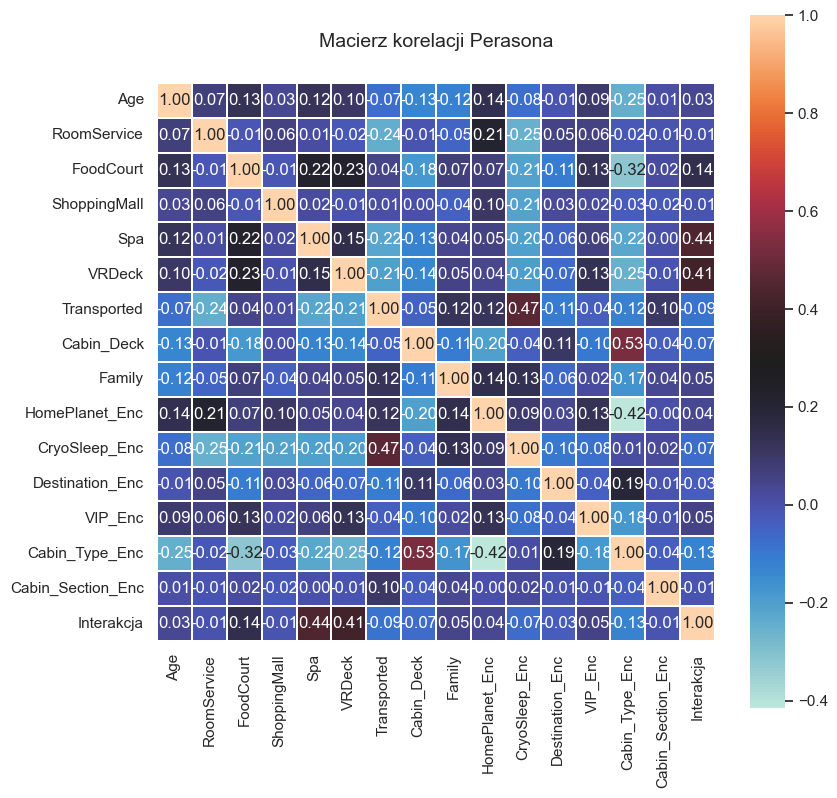

In [97]:
fig, ax = plt.subplots(figsize=(9, 9))
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, linecolor='white', annot=True, cmap= 'icefire', fmt=".2f")
ax.set_title('Macierz korelacji Perasona', y=1.05,   size=14)

In [98]:
train.groupby('Transported').mean().round(2)

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Cabin_Deck,Family,HomePlanet_Enc,CryoSleep_Enc,Destination_Enc,VIP_Enc,Cabin_Type_Enc,Cabin_Section_Enc,Interakcja
Transported,,,,,,,,,,,,,,,
0.0,29.87,7.41,4.83,5.78,8.85,10.33,625.01,0.2,0.57,0.14,1.57,0.03,4.52,0.45,168.34
1.0,27.75,1.24,6.63,6.09,0.99,1.36,576.58,0.3,0.76,0.59,1.39,0.02,4.10,0.56,5.96


## Modele Predykcyjne

In [99]:
#Biblioteki
from sklearn.preprocessing   import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.metrics         import make_scorer, f1_score, accuracy_score

from sklearn.neural_network  import MLPClassifier

from sklearn.ensemble        import RandomForestClassifier
from sklearn.ensemble        import AdaBoostClassifier
from sklearn.ensemble        import GradientBoostingClassifier
from sklearn.ensemble        import HistGradientBoostingClassifier

from sklearn.naive_bayes     import GaussianNB

from sklearn.svm             import NuSVC

from sklearn.neighbors       import KNeighborsClassifier

from catboost                import CatBoostClassifier

In [100]:
#Baza danych
X_train = train.drop('Transported',axis=1)
y_train = train['Transported']

X_test = test
y_test = []

testt = pd.read_csv("test.csv")
submission_df1 = pd.DataFrame({"PassengerId": testt['PassengerId']})



In [101]:
#Modele które zostaną wykorzystane
classifiers = [['Random Forest',RandomForestClassifier()],
               ['AdaBoost',AdaBoostClassifier()],
               ['Gradient Boosting',GradientBoostingClassifier()],
               ['Nu Support Vector Machine', NuSVC()], 
               ['HGBC',HistGradientBoostingClassifier()], 
               ['Naive Bayes',GaussianNB()],
               ['Cat', CatBoostClassifier(verbose=False)],
              ]

In [102]:
## Wstępna ocena wydajności modeli z domyślnymi parametrami
import warnings
warnings.simplefilter('ignore')

for metric in ['accuracy','f1']:
    SKfold = RepeatedStratifiedKFold(n_splits=4, n_repeats=5)
    score_mean = []
    std = []
    
    for model in classifiers:
        clf = model[1]
        cv_result = cross_val_score(clf,X_train, y_train, cv = SKfold, scoring = metric, n_jobs=-1)
        cv_result = cv_result
        score_mean.append(cv_result.mean())
        std.append(cv_result.std())
        
    models_evaluation = pd.DataFrame({metric: score_mean}, index=[i[0] for i in classifiers])
    print(models_evaluation.sort_values(metric, ascending=False))
    print('*'*32)

                           accuracy
Cat                        0.810676
HGBC                       0.810308
Gradient Boosting          0.804279
Random Forest              0.799356
AdaBoost                   0.791486
Nu Support Vector Machine  0.784999
Naive Bayes                0.645853
********************************
                                 f1
Cat                        0.814123
Gradient Boosting          0.811187
HGBC                       0.810752
Nu Support Vector Machine  0.804388
AdaBoost                   0.800125
Random Forest              0.793042
Naive Bayes                0.729316
********************************


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, make_scorer

param_grids = {
    'Random Forest': {
        'n_estimators': [100, 125, 150, 175, 200, 225, 250, 300],
        'max_depth': [5, 6, 7, 8, 9, 10 ,11, 12]
    },
    'AdaBoost': {
        'n_estimators': [140, 160, 175, 195, 205, 225, 245],
        'learning_rate': [0.75, 0.75, 0.80, 0.85, 0.90, 0.95, 1.0]
    },
    'Gradient Boosting': {
        'n_estimators': [75, 100, 125, 150, 175, 200, 225, 250],
        'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]
    },
    'Nu Support Vector Machine': {
        'nu': [0.4, 0.5, 0.6],
        'kernel': ['linear', 'rbf']
    },
    'HGBC': {
        'learning_rate': [0.0025, 0.05, 0.0075, 0.1, 0.25, 0.5]
    }
}

# Perform GridSearchCV for each classifier with accuracy evaluation
for name, clf in classifiers:
    param_grid = param_grids[name]
    scoring = {'accuracy': make_scorer(accuracy_score), 'f1': make_scorer(f1_score)}
    grid_search = GridSearchCV(estimator=clf, param_grid=param_grids[name], cv=SKfold, scoring=scoring, refit='accuracy', n_jobs=-1)
  
    grid_search.fit(X_train, y_train)

    # Print the best model's accuracy and parameters
    best_model = grid_search.best_estimator_
    best_score = grid_search.best_score_
    best_params = grid_search.best_params_

    print(f"\n{name} Model:")
    print(f"Best Accuracy on Training Data: {best_score:.4f}")
    print(f"Best Parameters: {best_params}")


Random Forest Model:
Best Accuracy on Training Data: 0.8038
Best Parameters: {'max_depth': 12, 'n_estimators': 200}

AdaBoost Model:
Best Accuracy on Training Data: 0.7938
Best Parameters: {'learning_rate': 0.85, 'n_estimators': 140}


#### Stacking

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn import model_selection
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import  cross_val_score
from sklearn.metrics import accuracy_score  
warnings.simplefilter('ignore')

estimators = [
    ('Random Forest', RandomForestClassifier(n_estimators=250, max_depth = 12)),
    ('Ada Boost', AdaBoostClassifier(learning_rate=0.75,n_estimators = 145)),
    ('Gradient Boosting', GradientBoostingClassifier(n_estimators=200, learning_rate=0.1 )),
    ('Cat', CatBoostClassifier(verbose=False)),
    ('HGBC', HistGradientBoostingClassifier(learning_rate=0.05)),
    ('NuSVC',NuSVC()),
     ]

# Final estimator
final_estimator = LogisticRegressionCV()
clf = StackingClassifier(estimators=estimators, final_estimator=final_estimator)

# Perform cross-validation for each model and the StackingClassifier
for name, model in estimators:
    scores = cross_val_score(model, X_train, y_train, cv=SKfold, scoring='accuracy', n_jobs=-1)
    print(f"{name}: {scores.mean():.3f} (+/- {scores.std():.3f})")
clf.fit(X_train,y_train) 

scores = cross_val_score(clf, X_train, y_train, cv=SKfold, scoring='accuracy', n_jobs=-1)
print(f"Stacking Classifier: {scores.mean():.3f} (+/- {scores.std():.3f})")

y_pred = clf.predict(X_test)


submission_df1['Transported'] = y_pred.astype('bool')
submission_df1 = submission_df1[['PassengerId', 'Transported']]
submission_df1.to_csv('submission1.csv', index=False)

# Ula lala
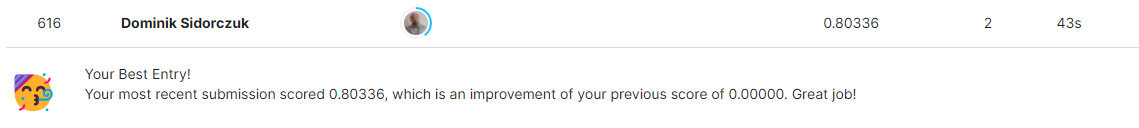